In [1]:
import kala
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

In [17]:
import seaborn as sns
from tqdm import tqdm

## Prelimaries

In [2]:
def _helper_diagonal_sbm(num_nodes, p_off, p_diag=1.0, seed=0, return_pos=True):
    n = num_nodes // 2
    sizes = [n, n + num_nodes % 2]

    p_mat = [
        [p_diag, p_off],
        [p_off, p_diag],
    ]

    g = nx.stochastic_block_model(sizes, p_mat, seed=seed)
    # g.graph["partition"]

    return g


def _helper_two_group_assigment(num_nodes, thresholds, seed=0):
    rng = np.random.default_rng(seed)

    n = num_nodes // 2
    sizes = [n, n + num_nodes % 2]
    block1 = rng.random(size=n) < thresholds[0]
    block2 = rng.random(size=n + num_nodes % 2) < thresholds[1]

    return np.hstack((block1, block2))


def _get_metrics(game, is_saver=None):
    n = game.get_num_players()
    return (
        game.get_total_wealth() / n,
        game.get_num_savers() / n,
        # game.get_total_wealth(filt=is_saver),
        # game.get_total_wealth(filt=~is_saver),
    )

In [3]:
def helper_init(
    num_players,
    group_thresholds,
    differential_efficient,
    differential_inefficient,
    sigma,
    memory_length,
    update_rule,
    rng=0,
):
    # Initialise strategy
    strategy = kala.CooperationStrategy(
        stochastic=True,
        rng=rng,
        differential_efficient=differential_efficient,
        differential_inefficient=differential_inefficient,
        dist_sigma_func=sigma,
    )

    # Initialise players
    is_saver = _helper_two_group_assigment(num_players, thresholds=group_thresholds)
    players = [
        kala.InvestorAgent(
            is_saver=s,
            update_from_n_last_games=memory_length,
            update_rule=update_rule,
        )
        for s in is_saver
    ]

    # Initialise network
    g = _helper_diagonal_sbm(num_players, p_off=0.1)
    G = kala.SimpleGraph(g, nodes=players)

    # Combine everything and initialise game
    game = kala.DiscreteTwoByTwoGame(G, strategy)

    return game, g, is_saver  # g, is_saver: returned for plotting


def helper_run_simulation(game, num_steps):
    game.reset_agents()

    data = [_get_metrics(game)]

    for _ in range(num_steps):
        game.play_round()
        data.append(_get_metrics(game))

    is_saver_final = [player.get_trait("is_saver") for player in game._players]

    return pd.DataFrame(data, columns=["avg_wealth", "frac_savers"]), is_saver_final


def helper_plot_simulation(df, g, savers_init, savers_final):
    pos = nx.spring_layout(g, seed=0)

    fig, axs = plt.subplots(ncols=3, figsize=(12, 4), width_ratios=(1, 1, 2))

    ax = axs[0]
    nx.draw(g, node_color=savers_init, pos=pos, ax=ax)
    ax.set_title("Init")

    ax = axs[1]
    nx.draw(g, node_color=savers_final, pos=pos, ax=ax)
    ax.set_title("Final")

    ax = axs[2]
    axes = [ax, ax.twinx()]

    for column, color, axis in zip(df.columns, ["C0", "C1"], axes):
        df[column].plot(color=color, ax=axis)
        axis.tick_params(axis="y", labelcolor=color)
        axis.set_ylabel(column, color=color);

# phase diagram

When introducing updating rules and memory, the percentage of savers will change over time. We are interested in knowing how different parameters determine the evolution of the system over time

In [45]:
# Constants

num_players = 40
group_thresholds = [0.5, 0.5]
num_steps = 100

sigma = lambda x: 1

Phase diagram for differential_efficient and differential_inefficient

In [ ]:
len_linspace = 20
start = 0.01
end = 0.99
space = np.linspace(start, end, len_linspace)

space

array([0.01      , 0.06157895, 0.11315789, 0.16473684, 0.21631579,
       0.26789474, 0.31947368, 0.37105263, 0.42263158, 0.47421053,
       0.52578947, 0.57736842, 0.62894737, 0.68052632, 0.73210526,
       0.78368421, 0.83526316, 0.88684211, 0.93842105, 0.99      ])

20it [01:35,  4.75s/it]


Text(50.722222222222214, 0.5, 'differential_inefficient')

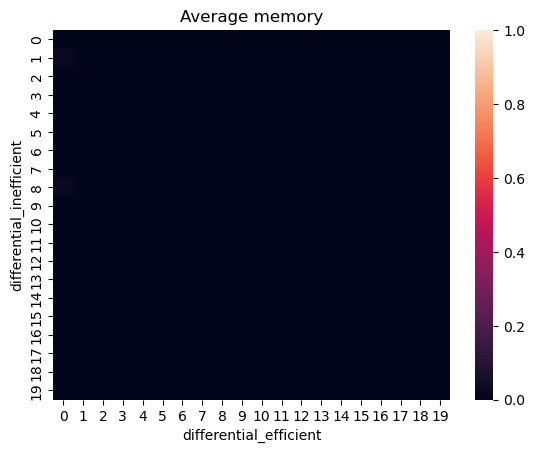

In [46]:
# Agent parameters
memory_length = 10
update_rule = kala.models.memory_rules.AverageMemoryRule()
# AverageMemoryRule(), FractionMemoryRule(fraction=0.9), AnyPastMemoryRule(), AllPastMemoryRule()

len_linspace = 20
start = 0.01
end = 0.99
space = np.linspace(start, end, len_linspace)

final_savers_arr = np.zeros((len_linspace, len_linspace))

for (i, differential_efficient) in tqdm(enumerate(space)):
    for (j, differential_inefficient) in enumerate(space):

        # Init
        game, g, savers_init = helper_init(
            num_players,
            group_thresholds,
            differential_efficient,
            differential_inefficient,
            sigma,
            memory_length,
            update_rule,
        )
        df, savers_final = helper_run_simulation(game, num_steps)

        final_savers_arr[i, j] = df.loc[num_steps, "frac_savers"]

sns.heatmap(final_savers_arr, vmin=0, vmax=1.)
plt.title("Average memory")
plt.xlabel("differential_efficient")
plt.ylabel("differential_inefficient")

20it [01:29,  4.49s/it]


Text(50.722222222222214, 0.5, 'differential_inefficient')

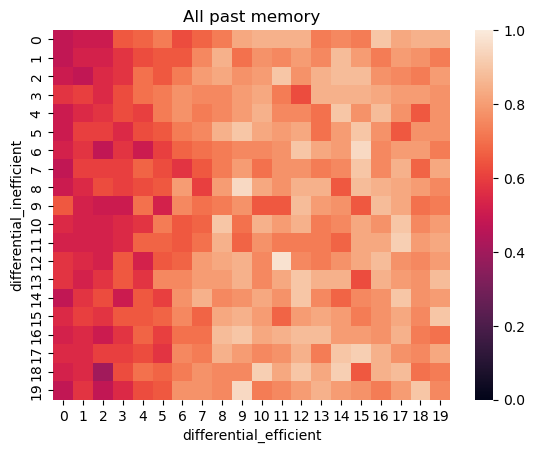

In [38]:
# Agent parameters
memory_length = 10
update_rule = kala.models.memory_rules.AllPastMemoryRule()
# AverageMemoryRule(), FractionMemoryRule(fraction=0.9), AnyPastMemoryRule(), AllPastMemoryRule()

len_linspace = 20
start = 0.01
end = 0.99
space = np.linspace(start, end, len_linspace)

final_savers_arr = np.zeros((len_linspace, len_linspace))

for (i, differential_efficient) in tqdm(enumerate(space)):
    for (j, differential_inefficient) in enumerate(space):

        # Init
        game, g, savers_init = helper_init(
            num_players,
            group_thresholds,
            differential_efficient,
            differential_inefficient,
            sigma,
            memory_length,
            update_rule,
        )
        df, savers_final = helper_run_simulation(game, num_steps)

        final_savers_arr[i, j] = df.loc[num_steps, "frac_savers"]

sns.heatmap(final_savers_arr, vmin=0, vmax=1.)
plt.title("All past memory")
plt.xlabel("differential_efficient")
plt.ylabel("differential_inefficient")

0it [00:00, ?it/s]

20it [01:30,  4.51s/it]


Text(50.722222222222214, 0.5, 'differential_inefficient')

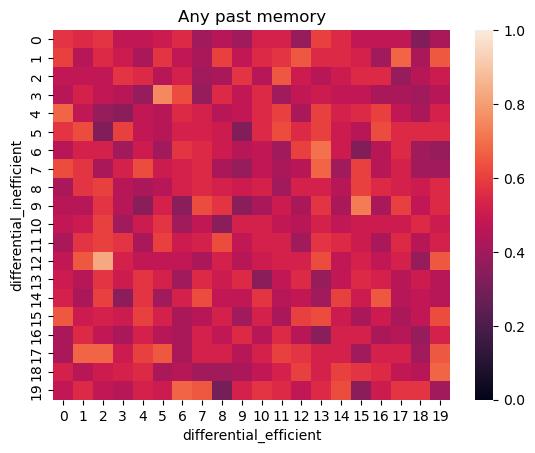

In [39]:
# Agent parameters
memory_length = 10
update_rule = kala.models.memory_rules.AnyPastMemoryRule()
# AverageMemoryRule(), FractionMemoryRule(fraction=0.9), AnyPastMemoryRule(), AllPastMemoryRule()

len_linspace = 20
start = 0.01
end = 0.99
space = np.linspace(start, end, len_linspace)

final_savers_arr = np.zeros((len_linspace, len_linspace))

for (i, differential_efficient) in tqdm(enumerate(space)):
    for (j, differential_inefficient) in enumerate(space):

        # Init
        game, g, savers_init = helper_init(
            num_players,
            group_thresholds,
            differential_efficient,
            differential_inefficient,
            sigma,
            memory_length,
            update_rule,
        )
        df, savers_final = helper_run_simulation(game, num_steps)

        final_savers_arr[i, j] = df.loc[num_steps, "frac_savers"]

sns.heatmap(final_savers_arr, vmin=0, vmax=1.)
plt.title("Any past memory")
plt.xlabel("differential_efficient")
plt.ylabel("differential_inefficient")

20it [01:32,  4.65s/it]


Text(50.722222222222214, 0.5, 'differential_inefficient')

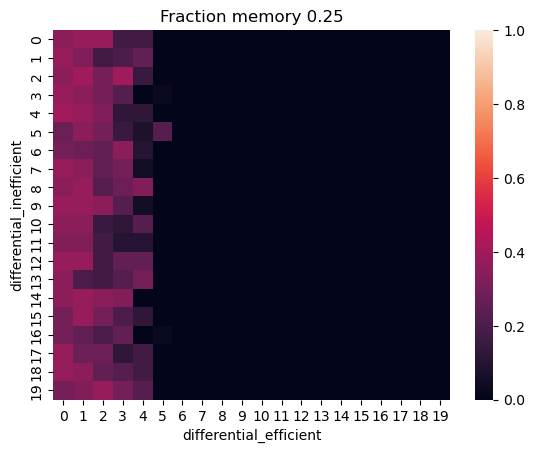

In [41]:
# Agent parameters
memory_length = 10
fraction = 0.25
update_rule = kala.models.memory_rules.FractionMemoryRule(fraction=fraction)
# AverageMemoryRule(), FractionMemoryRule(fraction=0.9), AnyPastMemoryRule(), AllPastMemoryRule()

len_linspace = 20
start = 0.01
end = 0.99
space = np.linspace(start, end, len_linspace)

final_savers_arr = np.zeros((len_linspace, len_linspace))

for (i, differential_efficient) in tqdm(enumerate(space)):
    for (j, differential_inefficient) in enumerate(space):

        # Init
        game, g, savers_init = helper_init(
            num_players,
            group_thresholds,
            differential_efficient,
            differential_inefficient,
            sigma,
            memory_length,
            update_rule,
        )
        df, savers_final = helper_run_simulation(game, num_steps)

        final_savers_arr[i, j] = df.loc[num_steps, "frac_savers"]

sns.heatmap(final_savers_arr, vmin=0, vmax=1.)
plt.title(f"Fraction memory {fraction}")
plt.xlabel("differential_efficient")
plt.ylabel("differential_inefficient")

20it [01:32,  4.61s/it]


Text(50.722222222222214, 0.5, 'differential_inefficient')

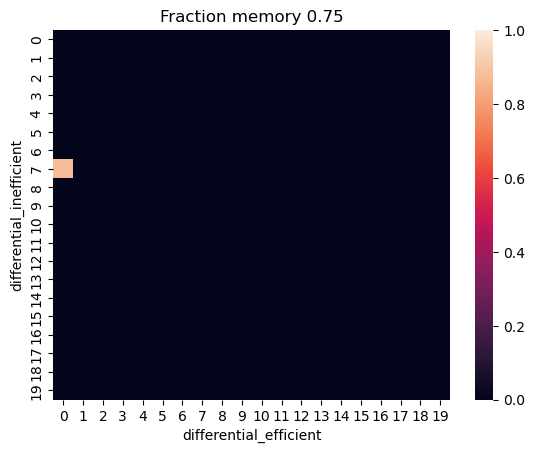

In [42]:
# Agent parameters
memory_length = 10
fraction = 0.75
update_rule = kala.models.memory_rules.FractionMemoryRule(fraction=fraction)
# AverageMemoryRule(), FractionMemoryRule(fraction=0.9), AnyPastMemoryRule(), AllPastMemoryRule()

len_linspace = 20
start = 0.01
end = 0.99
space = np.linspace(start, end, len_linspace)

final_savers_arr = np.zeros((len_linspace, len_linspace))

for (i, differential_efficient) in tqdm(enumerate(space)):
    for (j, differential_inefficient) in enumerate(space):

        # Init
        game, g, savers_init = helper_init(
            num_players,
            group_thresholds,
            differential_efficient,
            differential_inefficient,
            sigma,
            memory_length,
            update_rule,
        )
        df, savers_final = helper_run_simulation(game, num_steps)

        final_savers_arr[i, j] = df.loc[num_steps, "frac_savers"]

sns.heatmap(final_savers_arr, vmin=0, vmax=1.)
plt.title(f"Fraction memory {fraction}")
plt.xlabel("differential_efficient")
plt.ylabel("differential_inefficient")